# Draft Paper on Fast Multitask GPs

## Setup

In [1]:
import fastgps
import torch
torch.set_default_dtype(torch.float64)
import qmcpy as qp
import umbridge
import numpy as np 
import time
import pandas as pd
import itertools
import warnings
warnings.simplefilter("ignore")
import seaborn as sns
import matplotlib
from matplotlib import pyplot
pyplot.style.use("seaborn-v0_8-whitegrid")
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("../../../../xkcd_colors.txt",comment="#",header=None).iloc[:,0].tolist()][::-1]
pyplot.rcParams['axes.prop_cycle'] = matplotlib.cycler(color=COLORS)
LINESTYLES = ['solid','dotted','dashed','dashdot',(0, (1, 1))]
MARKERS = ["o","D","s"]
DEFAULTFONTSIZE = 30
pyplot.rcParams['xtick.labelsize'] = DEFAULTFONTSIZE
pyplot.rcParams['ytick.labelsize'] = DEFAULTFONTSIZE
pyplot.rcParams['ytick.labelsize'] = DEFAULTFONTSIZE
pyplot.rcParams['axes.titlesize'] = DEFAULTFONTSIZE
pyplot.rcParams['figure.titlesize'] = DEFAULTFONTSIZE
pyplot.rcParams["axes.labelsize"] = DEFAULTFONTSIZE
pyplot.rcParams['legend.fontsize'] = DEFAULTFONTSIZE
pyplot.rcParams['font.size'] = DEFAULTFONTSIZE
pyplot.rcParams['lines.linewidth'] = 5
pyplot.rcParams['lines.markersize'] = 15
PW = 30 # inches

## Points

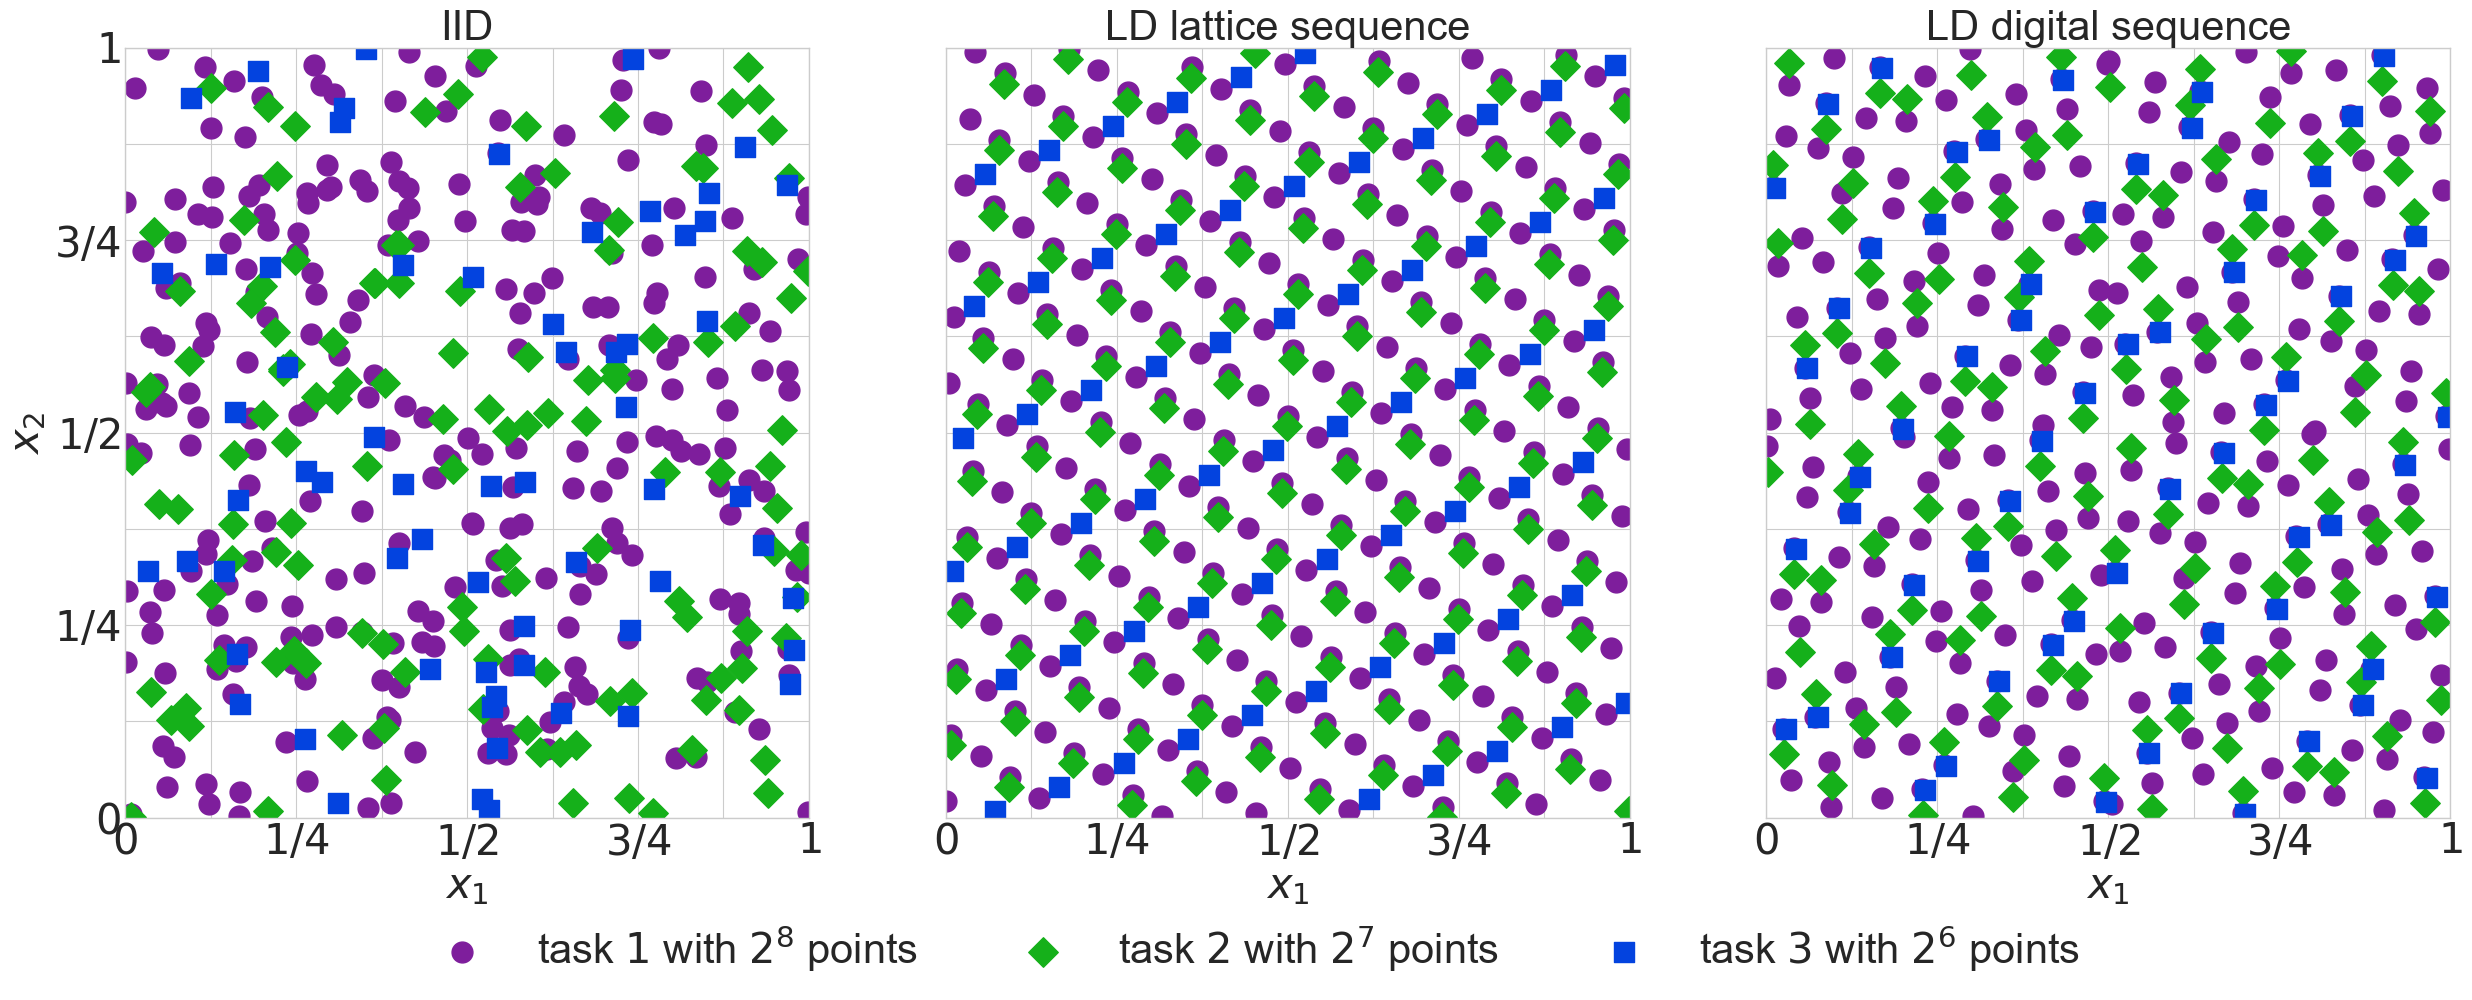

In [2]:
n = np.array([2**8,2**7,2**6],dtype=int)
assert np.all(np.log2(n)%1==0)
levels = len(n)
n_max = n.max()
point_sets = [
    ("IID",qp.IIDStdUniform(2,seed=11,replications=levels)(n_max)),
    ("LD lattice sequence",qp.Lattice(2,seed=5,replications=levels)(n_max)),
    ("LD digital sequence",qp.DigitalNet(2,seed=11,replications=levels,randomize="DS")(n_max)),
]
ncols = len(point_sets)
fig,ax = pyplot.subplots(nrows=1,ncols=ncols,figsize=(PW,PW/ncols),sharex=True,sharey=True)
for i in range(ncols):
    name,x = point_sets[i]
    for r in range(levels):
        x_r = x[r,:n[r],:]
        ax[i].scatter(x_r[:,0],x_r[:,1],color=COLORS[r],marker=MARKERS[r],label=(r"task $%d$ with $2^{%d}$ points"%(r+1,int(np.log2(n[r]))) if i==0 else None))
    ax[i].set_title(name)
    ax[i].set_xlabel(r"$x_1$");
ax[0].set_ylabel(r"$x_2$")
ax[0].set_xlim([0,1]); ax[0].set_xticks([0,1/8,1/4,3/8,1/2,5/8,3/4,7/8,1]); ax[0].set_xticklabels([r"$0$","",r"$1/4$","",r"$1/2$","",r"$3/4$","",r"$1$"])
ax[0].set_ylim([0,1]); ax[0].set_yticks([0,1/8,1/4,3/8,1/2,5/8,3/4,7/8,1]); ax[0].set_yticklabels([r"$0$","",r"$1/4$","",r"$1/2$","",r"$3/4$","",r"$1$"])
fig.legend(loc="lower center",ncols=levels,bbox_to_anchor=(1/2,-1/12))
fig.savefig("./points.pdf",bbox_inches="tight")

## Problems

### Benchmarks

In [2]:
def currin(level, x): # https://www.sfu.ca/~ssurjano/curretal88exp.html
    assert x.size(-1)==2 
    assert level in [0,1]
    x1,x2 = x[...,0],x[...,1]
    f = lambda x1,x2: (1-torch.exp(-1/(2*x2)))*(2300*x1**3+1900*x1**2+2092*x1+60)/(100*x1**3+500*x1**2+4*x1+20)
    if level==0:
        y = 1/4*(f(x1+0.05,x2+0.05)+f(x1+0.05,torch.maximum(torch.zeros(1),x2-0.05))+f(x1-0.05,x2+0.05)+f(x1-0.05,torch.maximum(torch.zeros(1),x2-0.05)))
    else:
        y = f(x1,x2)
    return y

def ackley(level, x): # https://www.sfu.ca/~ssurjano/ackley.html
    assert level in [0,1]
    a = 20
    b = 0.2 
    c = 0 if level==0 else 2*np.pi
    t = 2*32.768*x-32.768
    d = x.size(-1)
    y = -a*torch.exp(-b*torch.linalg.norm(t,dim=-1))-torch.exp(1/d*torch.cos(c*t).sum(-1))+a+np.exp(1)
    return y

def park1(level, x): # https://www.sfu.ca/~ssurjano/park91a.html
    assert x.size(-1)==4 
    assert level in [0,1]
    x1,x2,x3,x4 = x[...,0],x[...,1],x[...,2],x[...,3]
    y = x1/2*(torch.sqrt(1+(x2+x3**2)*x4/x1**2)-1)+(x1+3*x4)*torch.exp(1+torch.sin(x3))
    if level==0:
        y = (1+torch.sin(x1)/10)*y-2*x1+x2**2+x3**2+0.5
    return y 

def park2(level, x): # https://www.sfu.ca/~ssurjano/park91b.html
    assert x.size(-1)==4 
    assert level in [0,1]
    x1,x2,x3,x4 = x[...,0],x[...,1],x[...,2],x[...,3]
    y = 2/3*torch.exp(x1+x2)-x4*torch.sin(x3)+x3
    if level==0:
        y = 1.2*y-1
    return y 

def borehole(level, x): # https://www.sfu.ca/~ssurjano/borehole.html
    assert level in [0,1]
    assert x.size(-1)==8
    x = x.numpy()
    import scipy.stats
    rw = torch.from_numpy(scipy.stats.norm(loc=0.10,scale=0.0161812).ppf(x[...,0]))
    r  = torch.from_numpy(scipy.stats.lognorm(scale=np.exp(7.71),s=1.0056).ppf(x[...,1]))
    Tu = torch.from_numpy(scipy.stats.uniform(loc=63070,scale=115600-63070).ppf(x[...,2]))
    Hu = torch.from_numpy(scipy.stats.uniform(loc=990,scale=1110-990).ppf(x[...,3]))
    Tl = torch.from_numpy(scipy.stats.uniform(loc=63.1,scale=116-63.1).ppf(x[...,4]))
    Hl = torch.from_numpy(scipy.stats.uniform(loc=700,scale=820-700).ppf(x[...,5]))
    L  = torch.from_numpy(scipy.stats.uniform(loc=1120,scale=1680-1120).ppf(x[...,6]))
    Kw = torch.from_numpy(scipy.stats.uniform(loc=9855,scale=12045-9855).ppf(x[...,7]))
    C1 = 5 if level==0 else 2
    C2 = 1.5 if level==0 else 1
    frac1 = C1 * torch.pi * Tu * (Hu-Hl)
    frac2a = 2*L*Tu / (torch.log(r/rw)*rw**2*Kw)
    frac2b = Tu / Tl
    frac2 = torch.log(r/rw) * (C2+frac2a+frac2b)
    y = frac1 / frac2
    return y

def elliptic(level, x):
    from scipy.sparse import diags
    from scipy.sparse.linalg import spsolve
    from scipy.stats import norm
    coeffs = x.numpy()
    # Define grid
    N = 2**level  # Number of intervals
    h = 1.0 / N  # Mesh spacing
    x = np.linspace(h, 1 - h, N - 1)  # Interior points
    # Compute diffusion coefficient a(x)
    coeffs = np.random.rand(8) if coeffs is None else coeffs
    assert isinstance(coeffs,np.ndarray)
    coeffs = norm.ppf(coeffs)  # Transform from uniform to iid Gaussian
    batch_shape = list(coeffs.shape)[:-1]
    k = np.arange(1,coeffs.shape[-1]+1)
    a_x = np.exp((coeffs[...,None] / k[:,None]  *np.sin(np.pi * k[:,None] * x)).sum(-2))
    # Compute a at half-grid points (needed for flux terms)
    a_half = np.zeros(batch_shape+[N])
    a_half[...,1:-1] = (a_x[...,:-1] + a_x[...,1:]) / 2  # Midpoint values for flux approximation
    a_half[...,0] = a_x[...,0]  # At the first midpoint
    a_half[...,-1] = a_x[...,-1]  # At the last midpoint
    # Construct the finite difference matrix
    lower_diag = -a_half[...,1:-1] / h**2
    upper_diag = -a_half[...,1:-1] / h**2
    main_diag = (a_half[...,:-1] + a_half[...,1:]) / h**2
    # Right-hand side (forcing term)
    b = np.ones([N-1])  # Constant source term (1)
    def _spsolve(main_diag, upper_diag, lower_diag, b):
        N = main_diag.shape[-1]
        assert main_diag.shape==(N,) and upper_diag.shape==(N-1,) and lower_diag.shape==(N-1,) and b.shape==(N,)
        A = diags([main_diag, upper_diag, lower_diag],[0, 1, -1],shape=[N,N],format="csc",)
        u = spsolve(A, b)
        return u
    vec_spsolve = np.vectorize(_spsolve,signature="(n),(m),(m),(n)->(n)")
    u = vec_spsolve(main_diag, upper_diag, lower_diag, b)
    # Find index closest to x = 0.5
    idx = np.argmin(np.abs(x - 0.5))
    # return u[...,idx], u, x, a_x, x[idx]
    # return torch.from_numpy(u[...,idx])
    return torch.from_numpy(u.max(-1))

def asian_option(level, x):
    assert level>0
    d = 2**level
    assert x.size(-1)>=d
    ao = qp.FinancialOption(
        qp.IIDStdUniform(d),
        option = "ASIAN",
        call_put = "CALL",
        asian_mean = "GEOMETRIC",
        asian_mean_quadrature_rule = "RIGHT",
        volatility = 0.2, 
        start_price = 100, 
        strike_price = 100, 
        interest_rate = 0.05, 
        t_final = 1, 
    )
    y = torch.from_numpy(ao.f(x[...,:d].numpy()))
    return y

### MUQ Beam

In [3]:
def muq_beam(level, x): # https://um-bridge-benchmarks.readthedocs.io/en/docs/forward-benchmarks/muq-beam-propagation.html
    # docker run -it -p 4243:4243 linusseelinger/benchmark-muq-beam-propagation:latest
    assert level in [0]
    true_measure = qp.Uniform(qp.IIDStdUniform(3),lower_bound=1,upper_bound=1.05)
    um_bridge_model = umbridge.HTTPModel('http://localhost:4243','forward')
    um_bridge_config = {}
    integrand = qp.UMBridgeWrapper(true_measure,um_bridge_model,um_bridge_config,parallel=10)
    y = torch.from_numpy(integrand.f(x.numpy()))
    return y
if False: # uncomment to generate MUQ data
    dseq = qp.DigitalNet(3,randomize="DS",seed=7)
    x = torch.from_numpy(dseq(2**15))
    y = muq_beam(0,x)
    muq_data = {"x":x,"y":y}
    print(muq_data)
    torch.save(muq_data,"./muq_data.pt")

### Cookie

In [4]:
def cookie(level, x): # https://um-bridge-benchmarks.readthedocs.io/en/docs/forward-benchmarks/cookies-problem-propagation.html
    # docker run -p 4242:4242 -it linusseelinger/cookies-problem:latest
    assert level in [1,2,3,4]
    true_measure = qp.Uniform(qp.IIDStdUniform(8),lower_bound=-0.99,upper_bound=-0.2)
    um_bridge_model = umbridge.HTTPModel('http://localhost:4242','forward')
    um_bridge_config = {"Fidelity":level}
    integrand = qp.UMBridgeWrapper(true_measure,um_bridge_model,um_bridge_config,parallel=10)
    y = torch.from_numpy(integrand.f(x.numpy()))
    return y
if False: # uncomment to generate cookie data
    cookie_data = {}
    dseqs = [qp.DigitalNet(8,randomize="DS",seed=7+i) for i in range(4)]
    levelops = [1,2,3,4]
    for l in range(len(levelops)):
        x = torch.from_numpy(dseqs[l](2**12))
        y = cookie(levelops[l],x)
        cookie_data[levelops[l]] = (x,y) 
    print(cookie_data)
    torch.save(cookie_data,"./cookie_data.pt")

In [5]:
def cookie_pregen(level, x):
    assert level in [1,2,3,4]
    assert x.ndim==2 and x.size(-1)==8
    cookie_data = torch.load("./cookie_data.pt")
    x_data,y_data = cookie_data[level]
    x_data = x_data[:x.size(0)]
    y_data = y_data[:x.size(0)]
    assert (x_data==x).all()
    return y_data

## Solvers

In [7]:
def fit_gps(func, 
        d, 
        levelops, 
        n, 
        iterations, 
        xtest, 
        fit_std_gp, 
        fit_gpytorch_gp, 
        fit_fgpdnet, 
        fit_fgplat, 
        requires_grad_noise, 
        seeds, 
        rank, 
        sgp_threshold, 
        gpt_threshold,
        verbose,
        predlevels,
        compute_muhats,
        compute_sigmahats,
        n_gp,
        n_gpt, 
        n_fgpdnet,
        n_fgplat,):
    levels = len(levelops)
    assert n.shape==(levels,)
    seqs_dnet = [qp.DigitalNet(dimension=d,randomize="DS",seed=seeds[l]) for l in range(levels)]
    xs_dnet = [torch.from_numpy(seqs_dnet[l](n[l])) for l in range(levels)]
    ys_dnet = [func(levelops[l],xs_dnet[l]) for l in range(levels)]
    times = []
    yhattests = []
    muhats = []
    sigmahats = []
    if fit_std_gp: # standard GP
        if n_gp is not None:
            assert n_gp.shape==n.shape and (n_gp<=n).all()
        else:
            n_gp = n
        if n_gp.sum()>sgp_threshold:
            times.append(np.nan)
            yhattests.append(torch.nan*torch.empty(len(xtest)) if np.isscalar(predlevels) else torch.nan*torch.empty((len(predlevels),len(xtest))))
            if compute_muhats:
                muhats.append(torch.tensor(torch.nan) if np.isscalar(predlevels) else torch.nan*torch.ones(len(predlevels))) 
            if compute_sigmahats:
                sigmahats.append(torch.nan*torch.empty(len(xtest)) if np.isscalar(predlevels) else torch.nan*torch.empty((len(predlevels),len(xtest))))
        else:
            gp = fastgps.StandardGP(
                kernel=qp.KernelMultiTask(
                    base_kernel = qp.KernelSquaredExponential(d=d,torchify=True),
                    num_tasks = levels,
                    rank_factor = levels if rank is None else rank,),
                seqs=seqs_dnet,
                noise = 1e-4,
                adaptive_nugget = False,
                requires_grad_noise = requires_grad_noise)
            gp.add_y_next([ys_dnet[l][:n_gp[l]] for l in range(levels)])
            t0 = time.perf_counter()
            data = gp.fit(iterations=iterations,verbose=verbose,store_hists=True)
            times.append((time.perf_counter()-t0)/len(data["iteration"]))
            yhattests.append(gp.post_mean(xtest,task=predlevels))
            if compute_muhats:
                muhats.append(gp.post_cubature_mean(task=predlevels))
            if compute_sigmahats:
                sigmahats.append(torch.sqrt(gp.post_var(xtest,task=predlevels)))
    if fit_gpytorch_gp: # GPyTorch Multitask GP https://docs.gpytorch.ai/en/v1.6.0/examples/03_Multitask_Exact_GPs/Hadamard_Multitask_GP_Regression.html
        if n_gpt is not None:
            assert n_gpt.shape==n.shape and (n_gpt<=n).all()
        else:
            n_gpt = n
        if n_gpt.sum()>gpt_threshold:
            times.append(np.nan)
            yhattests.append(torch.nan*torch.empty(len(xtest)) if np.isscalar(predlevels) else torch.nan*torch.empty((len(predlevels),len(xtest))))
            if compute_muhats:
                muhats.append(torch.tensor(torch.nan) if np.isscalar(predlevels) else torch.nan*torch.ones(len(predlevels))) 
            if compute_sigmahats:
                sigmahats.append(torch.nan*torch.empty(len(xtest)) if np.isscalar(predlevels) else torch.nan*torch.empty((len(predlevels),len(xtest))))
        else:
            import gpytorch
            class MultitaskGPModel(gpytorch.models.ExactGP):
                def __init__(self, train_x, train_y, likelihood):
                    super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
                    self.mean_module = gpytorch.means.ZeroMean()
                    self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(ard_num_dims=d))
                    self.task_covar_module = gpytorch.kernels.IndexKernel(num_tasks=levels,rank=levels if rank is None else rank)
                def forward(self,x,i):
                    mean_x = self.mean_module(x)
                    covar_x = self.covar_module(x)
                    covar_i = self.task_covar_module(i)
                    covar = covar_x.mul(covar_i)
                    return gpytorch.distributions.MultivariateNormal(mean_x,covar)
            likelihood = gpytorch.likelihoods.GaussianLikelihood()
            likelihood.noise = 1e-4
            if not requires_grad_noise:
                likelihood.noise_covar.raw_noise.requires_grad_(False)
            _full_train_i = torch.cat([l*torch.ones((n_gpt[l],1),dtype=int) for l in range(levels)])
            _full_train_x = torch.cat([xs_dnet[l][:n_gpt[l]] for l in range(levels)])
            _full_train_y = torch.cat([ys_dnet[l][:n_gpt[l]] for l in range(levels)])
            gpt = MultitaskGPModel((_full_train_x,_full_train_i),_full_train_y, likelihood)
            gpt.train(); likelihood.train()
            optimizer = torch.optim.Rprop(gpt.parameters(),lr=0.1,etas=(0.5,1.2),step_sizes=(0,10))
            # optimizer = torch.optim.Adam(gpt.parameters(),lr=0.1)
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,gpt)
            t0 = time.perf_counter()
            for i in range(iterations):
                optimizer.zero_grad()
                output = gpt(_full_train_x,_full_train_i)
                loss = -mll(output, _full_train_y)
                if verbose and (i%verbose==0 or i==iterations-1): print("iter: %-7d GPT loss: %.2e"%(i,loss))
                loss.backward()
                optimizer.step()
            times.append((time.perf_counter()-t0)/iterations)
            gpt.eval(); likelihood.eval()
            with torch.no_grad(), gpytorch.settings.fast_pred_var():
                if np.isscalar(predlevels):
                    gpt_yhattest_mvngpt = gpt(xtest,predlevels*torch.ones((xtest.size(0),1),dtype=int))
                    gpt_yhattest = gpt_yhattest_mvngpt.mean
                    if compute_sigmahats:
                        sigmahats.append(torch.sqrt(gpt_yhattest_mvngpt.variance))
                else:
                    gpt_yhattest_mvns = [gpt(xtest,pl*torch.ones((xtest.size(0),1),dtype=int)) for pl in predlevels]
                    gpt_yhattest = torch.stack([mvn.mean for mvn in gpt_yhattest_mvns],axis=0)
                    if compute_sigmahats:
                        sigmahats.append(torch.sqrt(torch.stack([mvn.variance for mvn in gpt_yhattest_mvns],axis=0)))
            yhattests.append(gpt_yhattest)
            if compute_muhats:
                muhats.append(gpt_yhattest.mean(dim=-1)) # cannot exactly compute the mean, so just take a QMC estimate
    if fit_fgpdnet: # fast GP Dnet 
        if n_fgpdnet is not None:
            assert n_fgpdnet.shape==n.shape and (n_fgpdnet<=n).all()
        else:
            n_fgpdnet = n
        fgp_dnet = fastgps.FastGPDigitalNetB2(
            kernel = qp.KernelMultiTask(
                base_kernel = qp.KernelDigShiftInvarAdaptiveAlpha(d=d,torchify=True),
                num_tasks = levels,
                rank_factor = levels if rank is None else rank,),
            seqs=seqs_dnet,
            noise = 1e-4 if requires_grad_noise else 2*qp.util.transforms.EPS64,
            adaptive_nugget = False,
            requires_grad_noise = requires_grad_noise,)
        fgp_dnet.add_y_next([ys_dnet[l][:n_fgpdnet[l]] for l in range(levels)])
        t0 = time.perf_counter()
        data = fgp_dnet.fit(iterations=iterations,verbose=verbose,store_hists=True)
        times.append((time.perf_counter()-t0)/len(data["iteration"]))
        yhattests.append(fgp_dnet.post_mean(xtest,task=predlevels))
        if compute_muhats:
            muhats.append(fgp_dnet.post_cubature_mean(task=predlevels))
        if compute_sigmahats:
            sigmahats.append(torch.sqrt(fgp_dnet.post_var(xtest,task=predlevels)))
    if fit_fgplat: # fast GP lattice
        if n_fgplat is not None:
            assert n_fgplat.shape==n.shape and (n_fgplat<=n).all()
        else:
            n_fgplat = n
        seqs_lat = [qp.Lattice(dimension=d) for l in range(levels)]
        xs_lat = [torch.from_numpy(seqs_dnet[l](n_fgplat[l])) for l in range(levels)]
        # ys_lat = [func(l,xs_lat[l]) for l in range(levels)]
        ys_lat = [func(levelops[l],1-2*torch.abs(xs_lat[l]-1/2)) for l in range(levels)]
        fgp_lat = fastgps.FastGPLattice(
            kernel = qp.KernelMultiTask(
                base_kernel = qp.KernelShiftInvar(d=d,torchify=True,alpha=2),
                num_tasks = levels,
                rank_factor = levels if rank is None else rank),
            seqs = seqs_lat,
            noise = 1e-4 if requires_grad_noise else 2*qp.util.transforms.EPS64,
            adaptive_nugget = False,
            requires_grad_noise = requires_grad_noise,
            )
        fgp_lat.add_y_next([ys_lat[l][:n_fgplat[l]] for l in range(levels)])
        t0 = time.perf_counter()
        data = fgp_lat.fit(iterations=iterations,verbose=verbose,store_hists=True)
        times.append((time.perf_counter()-t0)/len(data["iteration"]))
        # fgp_lat_yhattest = fgp.post_mean(xtest,task=levels-1)
        yhattests.append(1/2*(fgp_lat.post_mean(xtest/2,task=predlevels)+fgp_lat.post_mean(1-xtest/2,task=predlevels)))
        muhats.append(fgp_lat.post_cubature_mean(task=predlevels))
        if compute_muhats:
            muhats.append(fgp_lat.post_cubature_mean(task=predlevels))
        if compute_sigmahats:
            sigmahats.append(torch.nan*torch.empty(torch.nan*torch.empty(len(xtest)) if np.isscalar(predlevels) else torch.nan*torch.empty((len(predlevels),len(xtest)))))
    return torch.tensor(times),torch.stack(yhattests,dim=0),(torch.stack(muhats,dim=0) if compute_muhats else None),(torch.stack(sigmahats,dim=0) if compute_sigmahats else None)
                                                                                                                     
def run(
        func, 
        d, 
        levelops, 
        ns, 
        iterations = 100, 
        trials = 1, 
        fit_std_gp = True, 
        fit_gpytorch_gp = True, 
        fit_fgpdnet = True, 
        fit_fgplat = False, 
        requires_grad_noise = False, 
        n_ref = 2**18, 
        n_test = 2**11, 
        ref_mu = None, 
        seeds = None, 
        test_data = None, 
        tf_output = lambda x: x,
        rank = None,
        sgp_threshold = 2**11,
        gpt_threshold = 2**12,
        verbose = False):
    levels = len(levelops)
    assert ns.ndim==2 and ns.size(1)==levels
    assert n_ref>=n_test
    num_ns = len(ns)
    num_gptypes = int(fit_std_gp)+int(fit_gpytorch_gp)+int(fit_fgpdnet)+int(fit_fgplat)
    gptypes = []
    if fit_std_gp: gptypes.append("Cholesky SE")
    if fit_gpytorch_gp: gptypes.append("CG SE (GPyTorch)")
    if fit_fgpdnet: gptypes.append("Fast DSI (ours)")
    if fit_fgplat: gptypes.append("Fast SI Lat (ours)")
    if test_data is None:
        xtest = torch.from_numpy(qp.Halton(dimension=d,randomize="QRNG",seed=11)(n_ref))
        ytest = func(levelops[-1],xtest)
    else:
        xtest,ytest = test_data
    if ref_mu is None:
        mu = ytest.mean() # true mean computed with large-sample QMC estimate
    else:
        mu = ref_mu
    times = torch.empty((num_gptypes,num_ns,trials))
    l2rerrors = torch.empty((num_gptypes,num_ns,trials))
    bcerrors = torch.empty((num_gptypes,num_ns,trials))
    if seeds is None: seeds = [None]*levels
    print("\tgptypes:",gptypes)
    print()
    print("\tns")
    for i in range(num_ns): print("\t\t%d: %s"%(i,ns[i].numpy()))
    print()
    print("\t~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print()
    t0 = time.perf_counter()
    for i in range(num_ns):
        print("\tns[%d] = %s"%(i,ns[i].numpy()))
        print("\t\t%-10s %-20s %-35s %-35s %-35s"%("trial","clock","times","l2rerrors","bcerrors"))
        for j in range(trials):
            times[:,i,j],yhattest,muhat,_ = fit_gps(func,d,levelops,ns[i],iterations,xtest[:n_test],fit_std_gp,fit_gpytorch_gp,fit_fgpdnet,fit_fgplat,requires_grad_noise,seeds,rank,sgp_threshold,gpt_threshold,verbose,predlevels=levels-1,compute_muhats=True,compute_sigmahats=False,n_gp=None,n_gpt=None,n_fgpdnet=None,n_fgplat=None)
            yhattest = tf_output(yhattest)
            l2rerrors[:,i,j] = torch.linalg.norm(yhattest-ytest[:n_test],dim=-1)/torch.linalg.norm(ytest[:n_test])
            bcerrors[:,i,j] = torch.abs(muhat-mu)
            with np.printoptions(formatter={"float":lambda x: "%.1e"%x}):
                print("\t\t%-10d %-20.1f %-35s %-35s %-35s"%(j,time.perf_counter()-t0,times[:,i,j].numpy(),l2rerrors[:,i,j].numpy(),bcerrors[:,i,j].numpy()))
        print()
    return gptypes,times,l2rerrors,bcerrors

## Examples

### Simple

In [ ]:
ns = torch.tensor([
    # [2**15,2**15],
    # [2**14,2**14],
    # [2**13,2**13],
    # [2**12,2**12],
    # [2**11,2**11],
    # [2**10,2**10],
    # [2**9,2**9],
    # [2**8,2**8],
    [2**7,2**7],
    [2**6,2**6],
    [2**5,2**5],
    [2**4,2**4]
    ],dtype=int)
gptypes,times,l2rerrors,bcerrors = run(currin,2,[0,1],ns)
with np.printoptions(formatter={"float":lambda x: "%-7.1e"%x},linewidth=np.inf):
    print()
    print("times.shape = %s"%str(tuple(times.shape)))
    print("times.median(dim=-1).values")
    print(times.nanmedian(dim=-1).values.numpy())
    print()
    print("l2rerrors.shape = %s"%str(tuple(l2rerrors.shape)))
    print("l2rerrors.median(dim=-1).values")
    print(l2rerrors.nanmedian(dim=-1).values.numpy())
    print()
    print("bcerrors.shape = %s"%str(tuple(bcerrors.shape)))
    print("bcerrors.median(dim=-1).values")
    print(bcerrors.nanmedian(dim=-1).values.numpy())

### Timing

In [ ]:
if False: # switch to True to run this cell
    m1ticks = torch.arange(15,5,-1)
    m2ticks = torch.arange(15,5,-1)
    m1mesh,m2mesh = torch.meshgrid(m1ticks,m2ticks,indexing="ij")
    ms = torch.stack([m1mesh.flatten(),m2mesh.flatten()],dim=-1)
    _,times_d10,_,_ = run(lambda l,x: x.sum(-1),10,[0,1],2**ms,iterations=1,trials=5,fit_std_gp=False,fit_gpytorch_gp=False,fit_fgpdnet=True,fit_fgplat=False,n_ref=2**3,n_test=2**2)
    _,times_d100,_,_ = run(lambda l,x: x.sum(-1),100,[0,1],2**ms,fit_std_gp=False,trials=5,fit_gpytorch_gp=False,fit_fgpdnet=True,fit_fgplat=False,n_ref=2**3,n_test=2**2)
    torch.save({"m1ticks":m1ticks,"m2ticks":m2ticks,"times_d10":times_d10,"times_d100":times_d100},"./timing.pt")

In [ ]:
data_timing = torch.load("./timing.pt")
m1ticks = data_timing["m1ticks"]
m2ticks = data_timing["m2ticks"]
times_d10 = data_timing["times_d10"]
times_d100 = data_timing["times_d100"]
fig,ax = pyplot.subplots(nrows=1,ncols=2,figsize=(PW,PW/2),sharex=False,sharey=False)
cmap = sns.color_palette("Blues", as_cmap=True) # https://seaborn.pydata.org/tutorial/color_palettes.html
# cmap = sns.cubehelix_palette(start=1/2, rot=-1/2, reverse=False, as_cmap=True)
# cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
fgp_timemesh_d10 = times_d10[0,].nanmedian(-1).values.reshape((len(m1ticks),len(m2ticks)))
fgp_timemesh_d100 = times_d100[0,].nanmedian(-1).values.reshape((len(m1ticks),len(m2ticks)))
heatmap_d10 = ax[0].pcolor(torch.log10(fgp_timemesh_d10).T,cmap=cmap) 
heatmap_d100 = ax[1].pcolor(torch.log10(fgp_timemesh_d100).T,cmap=cmap) 
for j in range(2):
    ax[j].set_xticks(np.arange(len(m1ticks))+1/2)
    ax[j].set_xticklabels([r"$2^{%d}$"%m for m in m1ticks])
    ax[j].set_yticks(np.arange(len(m2ticks))+1/2)
    ax[j].set_yticklabels([r"$2^{%d}$"%m for m in m2ticks])
    ax[j].invert_xaxis()
    ax[j].invert_yaxis()
    ax[j].tick_params(axis='both',which='major',pad=15)
    ax[j].set_xlabel(r"$n_1$")
    ax[j].set_ylabel(r"$n_2$")
ax[0].set_title(r"$d=10$")
ax[1].set_title(r"$d=100$")
for i in range(len(m1ticks)):
    for j in range(len(m2ticks)):
        ax[0].text(i+1/2,j+1/2,"%.2f"%np.log10(fgp_timemesh_d10[i,j].item()),ha="center",va="center",color="black")
        ax[1].text(i+1/2,j+1/2,"%.2f"%np.log10(fgp_timemesh_d100[i,j].item()),ha="center",va="center",color="black")
cax_d10 = fig.add_axes([ax[0].get_position().x0,ax[0].get_position().y0-.14,ax[0].get_position().x1-ax[0].get_position().x0,0.05])
cax_d100 = fig.add_axes([ax[1].get_position().x0,ax[1].get_position().y0-.14,ax[1].get_position().x1-ax[1].get_position().x0,0.05])
fig.colorbar(heatmap_d10,cax_d10,location="bottom",label=r"$\log_{10} \mathrm{time} $",extend="neither")
fig.colorbar(heatmap_d100,cax_d100,location="bottom",label=r"$\log_{10} \mathrm{time} $",extend="neither")
fig.savefig("./timing.pdf",bbox_inches="tight")

### Errors vs Times

In [8]:
if True: # uncomment to run simulations
    # name,func,d,levelops,ms = ("Currin",currin,2,[0,1],[13,12,11,10,9,8,7,6])
    # name,func,d,levelops,ms = ("Park1",park1,4,[0,1],[13,12,11,10,9,8,7,6])
    # name,func,d,levelops,ms = ("Park2",park2,4,[0,1],[13,12,11,10,9,8,7,6])
    name,func,d,levelops,ms = ("Ackley",ackley,4,[0,1],[16,15,14,13,12,11,10,9,8,7,6,5])
    # name,func,d,levelops,ms = ("Borehole",borehole,8,[0,1],[14,13,12,11,10,9,8,7,6,5])
    # name,func,d,levelops,ms = ("Elliptic",elliptic,16,[4,5,6],[13,11,9,7,5])
    # name,func,d,levelops,ms = ("Asian Option",asian_option,32,[8,16,32,64])
    # name,func,d,levelops,ms = ("Cookie",cookie_pregen,8,[1,2,3,4],[13,11,9,7,5])
    meshes = torch.meshgrid(*[torch.tensor(ms,dtype=int) for l in range(len(levelops))],indexing="ij")
    ns = 2**torch.stack([mesh.flatten() for mesh in meshes],dim=-1)
    print(name)
    if name=="Cookie":
        seeds = [7,8,9,10]
        cookie_data = torch.load("./cookie_data.pt")
        cookie_data_test = torch.load("./cookie_data.test.pt")
        test_data = (cookie_data_test[4][0][-2**12:],cookie_data_test[4][1][-2**12:])
        ref_mu = 0.064202350667514
    else:
        seeds = None 
        test_data = None
        ref_mu = None
    if name=="Asian Option":
        tf_output = lambda x: torch.maximum(x,torch.zeros(1))
    else:
        tf_output = lambda x: x
    gptypes,times,l2rerrors,bcerrors = run(func,d,levelops,ns,trials=5,seeds=seeds,test_data=test_data,ref_mu=ref_mu,tf_output=tf_output)
    torch.save({"ns":ns,"gptypes":gptypes,"times":times,"l2rerrors":l2rerrors,"bcerrors":bcerrors},"./runs.%s.pt"%name)

Ackley
	gptypes: ['Cholesky SE', 'CG SE (GPyTorch)', 'Fast DSI (ours)']

	ns
		0: [65536 65536]
		1: [65536 32768]
		2: [65536 16384]
		3: [65536  8192]
		4: [65536  4096]
		5: [65536  2048]
		6: [65536  1024]
		7: [65536   512]
		8: [65536   256]
		9: [65536   128]
		10: [65536    64]
		11: [65536    32]
		12: [32768 65536]
		13: [32768 32768]
		14: [32768 16384]
		15: [32768  8192]
		16: [32768  4096]
		17: [32768  2048]
		18: [32768  1024]
		19: [32768   512]
		20: [32768   256]
		21: [32768   128]
		22: [32768    64]
		23: [32768    32]
		24: [16384 65536]
		25: [16384 32768]
		26: [16384 16384]
		27: [16384  8192]
		28: [16384  4096]
		29: [16384  2048]
		30: [16384  1024]
		31: [16384   512]
		32: [16384   256]
		33: [16384   128]
		34: [16384    64]
		35: [16384    32]
		36: [ 8192 65536]
		37: [ 8192 32768]
		38: [ 8192 16384]
		39: [8192 8192]
		40: [8192 4096]
		41: [8192 2048]
		42: [8192 1024]
		43: [8192  512]
		44: [8192  256]
		45: [8192  128]
		46: [8192   64]
		47: [81

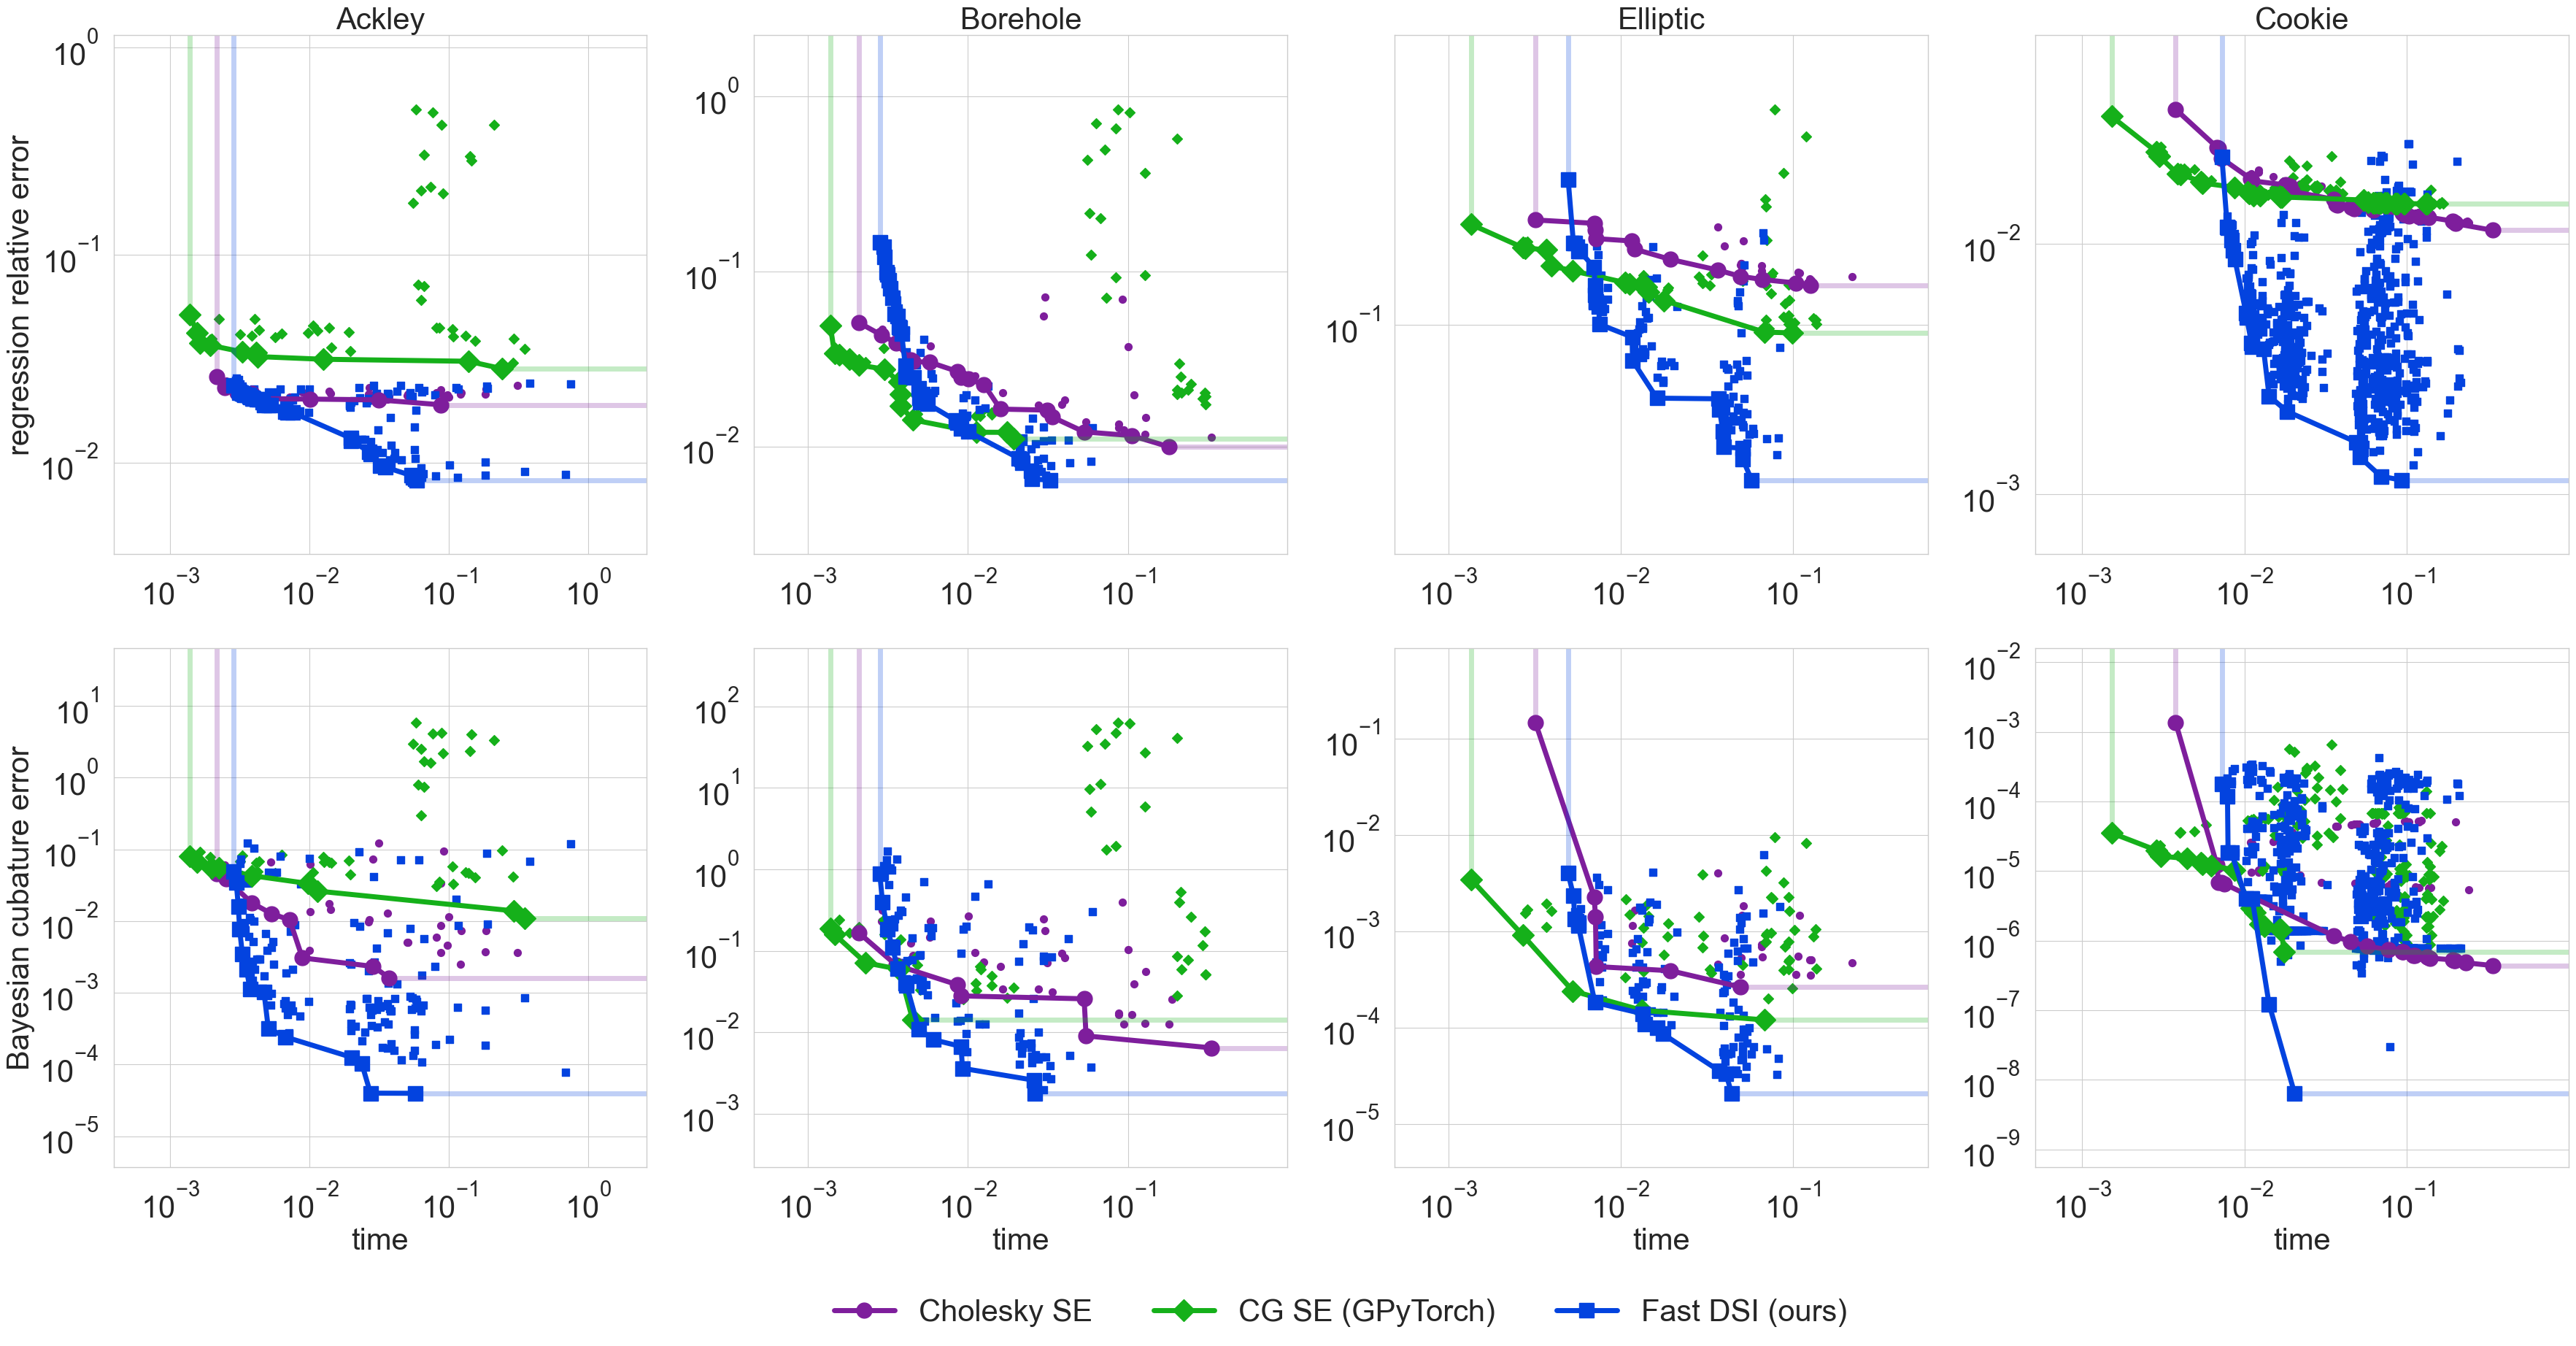

In [9]:
names = [
    "Ackley",
    "Borehole",
    "Elliptic",
    "Cookie"
    ]
MSP = 15
MSNP = 50
ALPHA = 0.25
EXPAND = 0.2
ncols = len(names)
nrows = 2
fig,ax = pyplot.subplots(nrows=nrows,ncols=ncols,figsize=(1.2*PW,1.2*PW/ncols*nrows),sharex="col",sharey=False)
ax = np.atleast_1d(ax).reshape((nrows,ncols))
for j in range(ncols):
    name = names[j]
    data_runs = torch.load("./runs.%s.pt"%name)
    gptypes = data_runs["gptypes"]
    mtimes_all = data_runs["times"].nanmedian(-1).values
    ml2rerrors_all = data_runs["l2rerrors"].nanmedian(-1).values
    mbcerrors_all = data_runs["bcerrors"].nanmedian(-1).values
    xmin,xmax = np.log10(mtimes_all[mtimes_all.isfinite()].min()),np.log10(mtimes_all[mtimes_all.isfinite()].max())
    ymin_0,ymax_0 = np.log10(ml2rerrors_all[ml2rerrors_all.isfinite()].min()),np.log10(ml2rerrors_all[ml2rerrors_all.isfinite()].max())
    ymin_1,ymax_1 = np.log10(mbcerrors_all[mbcerrors_all.isfinite()].min()),np.log10(mbcerrors_all[mbcerrors_all.isfinite()].max())
    ax[0,j].set_xlim([10**(xmin-EXPAND*(xmax-xmin)),10**(xmax+EXPAND*(xmax-xmin))])
    ax[0,j].set_ylim([10**(ymin_0-EXPAND*(ymax_0-ymin_0)),10**(ymax_0+EXPAND*(ymax_0-ymin_0))])
    ax[1,j].set_ylim([10**(ymin_1-EXPAND*(ymax_1-ymin_1)),10**(ymax_1+EXPAND*(ymax_1-ymin_1))])
    for i in range(len(gptypes)):
        mtimes = mtimes_all[i]
        ml2rerrors = ml2rerrors_all[i]
        mbcerrors = mbcerrors_all[i]
        ax[0,j].scatter(mtimes,ml2rerrors,marker=MARKERS[i],color=COLORS[i],s=MSNP)
        ax[1,j].scatter(mtimes,mbcerrors,marker=MARKERS[i],color=COLORS[i],s=MSNP)
        better_times = mtimes[:,None]<mtimes[None,:]
        better_l2rerrors = ml2rerrors[:,None]<ml2rerrors[None,:]
        better_bcerrors = mbcerrors[:,None]<mbcerrors[None,:]
        fpareto_l2rerrors = ~(better_times*better_l2rerrors).any(0)
        mtimes_pareto_l2rerrors = mtimes[fpareto_l2rerrors*mtimes.isfinite()*ml2rerrors.isfinite()]
        ml2rerrors_pareto = ml2rerrors[fpareto_l2rerrors*mtimes.isfinite()*ml2rerrors.isfinite()]
        ord_pareto_l2errors = mtimes_pareto_l2rerrors.argsort()
        mtimes_pareto_l2rerrors_sort = mtimes_pareto_l2rerrors[ord_pareto_l2errors]
        ml2rerrors_pareto_sort = ml2rerrors_pareto[ord_pareto_l2errors]
        ax[0,j].plot(mtimes_pareto_l2rerrors_sort,ml2rerrors_pareto_sort,marker=MARKERS[i],color=COLORS[i],markersize=MSP,label=gptypes[i] if j==0 else None)
        ax[0,j].hlines(y=ml2rerrors_pareto_sort[-1].item(),xmin=mtimes_pareto_l2rerrors_sort[-1].item(),xmax=ax[0,j].get_xlim()[1],color=COLORS[i],alpha=ALPHA)
        ax[0,j].vlines(x=mtimes_pareto_l2rerrors_sort[0].item(),ymin=ml2rerrors_pareto_sort[0].item(),ymax=ax[0,j].get_ylim()[1],color=COLORS[i],alpha=ALPHA)
        fpareto_bcerrors = ~(better_times*better_bcerrors).any(0)
        mtimes_pareto_bcerrors = mtimes[fpareto_bcerrors*mtimes.isfinite()*mbcerrors.isfinite()]
        mbcerrors_pareto = mbcerrors[fpareto_bcerrors*mtimes.isfinite()*mbcerrors.isfinite()]
        ord_pareto_bcerrors = mtimes_pareto_bcerrors.argsort()
        mtimes_pareto_bcerrors_sort = mtimes_pareto_bcerrors[ord_pareto_bcerrors]
        mbcerrors_pareto_sort = mbcerrors_pareto[ord_pareto_bcerrors]
        ax[1,j].plot(mtimes_pareto_bcerrors_sort,mbcerrors_pareto_sort,marker=MARKERS[i],color=COLORS[i],markersize=MSP)
        ax[1,j].hlines(y=mbcerrors_pareto_sort[-1].item(),xmin=mtimes_pareto_bcerrors_sort[-1].item(),xmax=ax[1,j].get_xlim()[1],color=COLORS[i],alpha=ALPHA)
        ax[1,j].vlines(x=mtimes_pareto_bcerrors_sort[0].item(),ymin=mbcerrors_pareto_sort[0].item(),ymax=ax[1,j].get_ylim()[1],color=COLORS[i],alpha=ALPHA)
    ax[0,j].set_title(name)
    for i in range(2):
        ax[i,j].set_xscale("log",base=10)
        ax[i,j].set_yscale("log",base=10)
        ax[-1,j].set_xlabel("time")
        ax[0,0].set_ylabel(r"regression relative error")
        ax[1,0].set_ylabel(r"Bayesian cubature error")
        ax[i,j].tick_params(labelbottom=True,axis='both',which='major',pad=15)
fig.legend(loc="lower center",ncols=len(gptypes),bbox_to_anchor=(0.52,-1/20))
fig.tight_layout()
fig.savefig("./errors.pdf",bbox_inches="tight")

### MUQ Beam

In [38]:
muq_data = torch.load("./muq_data.pt")
x_muq = muq_data["x"]
y_muq = muq_data["y"]
def muq_pregen(level, x):
    assert 0<=level<31
    x_data = x_muq[:x.size(0)]
    y_data = y_muq[:,:x.size(0)]
    assert (x_data==x).all()
    return y_data[level]
x_muq_test = x_muq[-2**8:]
y_muq_test = y_muq[:,-2**8:]
times,yhatts,muhats,sigmahats = fit_gps(
    func = muq_pregen,
    d = 3, 
    levelops = [i for i in range(31)],
    n = 2**10*torch.ones(31,dtype=int),
    iterations = 50,
    xtest = x_muq_test,
    fit_std_gp = True,
    fit_gpytorch_gp = True, 
    fit_fgpdnet = True, 
    fit_fgplat = False,
    requires_grad_noise = False, 
    seeds = [7 for i in range(31)],
    rank = 31, 
    sgp_threshold = 2**12, 
    gpt_threshold = 2**12,
    verbose = 5, 
    predlevels = [i for i in range(31)],
    compute_muhats = True,
    compute_sigmahats = False,
    n_gp = 2**5*torch.ones(31,dtype=int),
    n_gpt = 2**5*torch.ones(31,dtype=int),
    n_fgpdnet = 2**8*torch.ones(31,dtype=int),
    n_fgplat = None,)
print("times:",times)
print(yhatts.shape) 
print(muhats.shape) 
# print(sigmahats.shape) 

     iter of 5.0e+01 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 5.67e+05   | 5.67e+05  
            5.00e+00 | 2.73e+03   | 2.73e+03  
            1.00e+01 | 1.75e+02   | 1.75e+02  
            1.50e+01 | -5.31e+02  | -5.31e+02 
            1.80e+01 | -7.34e+02  | -8.46e+02 
iter: 0       GPT loss: 6.84e+03
iter: 5       GPT loss: 1.76e+02
iter: 10      GPT loss: 3.02e+01
iter: 15      GPT loss: 8.56e+00
iter: 20      GPT loss: 4.32e+00
iter: 25      GPT loss: 3.51e+00
iter: 30      GPT loss: 3.35e+00
iter: 35      GPT loss: 3.29e+00
iter: 40      GPT loss: 3.26e+00
iter: 45      GPT loss: 3.23e+00
iter: 49      GPT loss: 3.21e+00
     iter of 5.0e+01 | best loss  | loss      
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
            0.00e+00 | 1.54e+05   | 1.54e+05  
            5.00e+00 | 1.96e+04   | 1.96e+04  
            1.00e+01 | 5.78e+03   | 5.78e+03  
            1.50e+01 | 2.32e+03   | 2.32e+03  
            2.00e+01 | 5.3

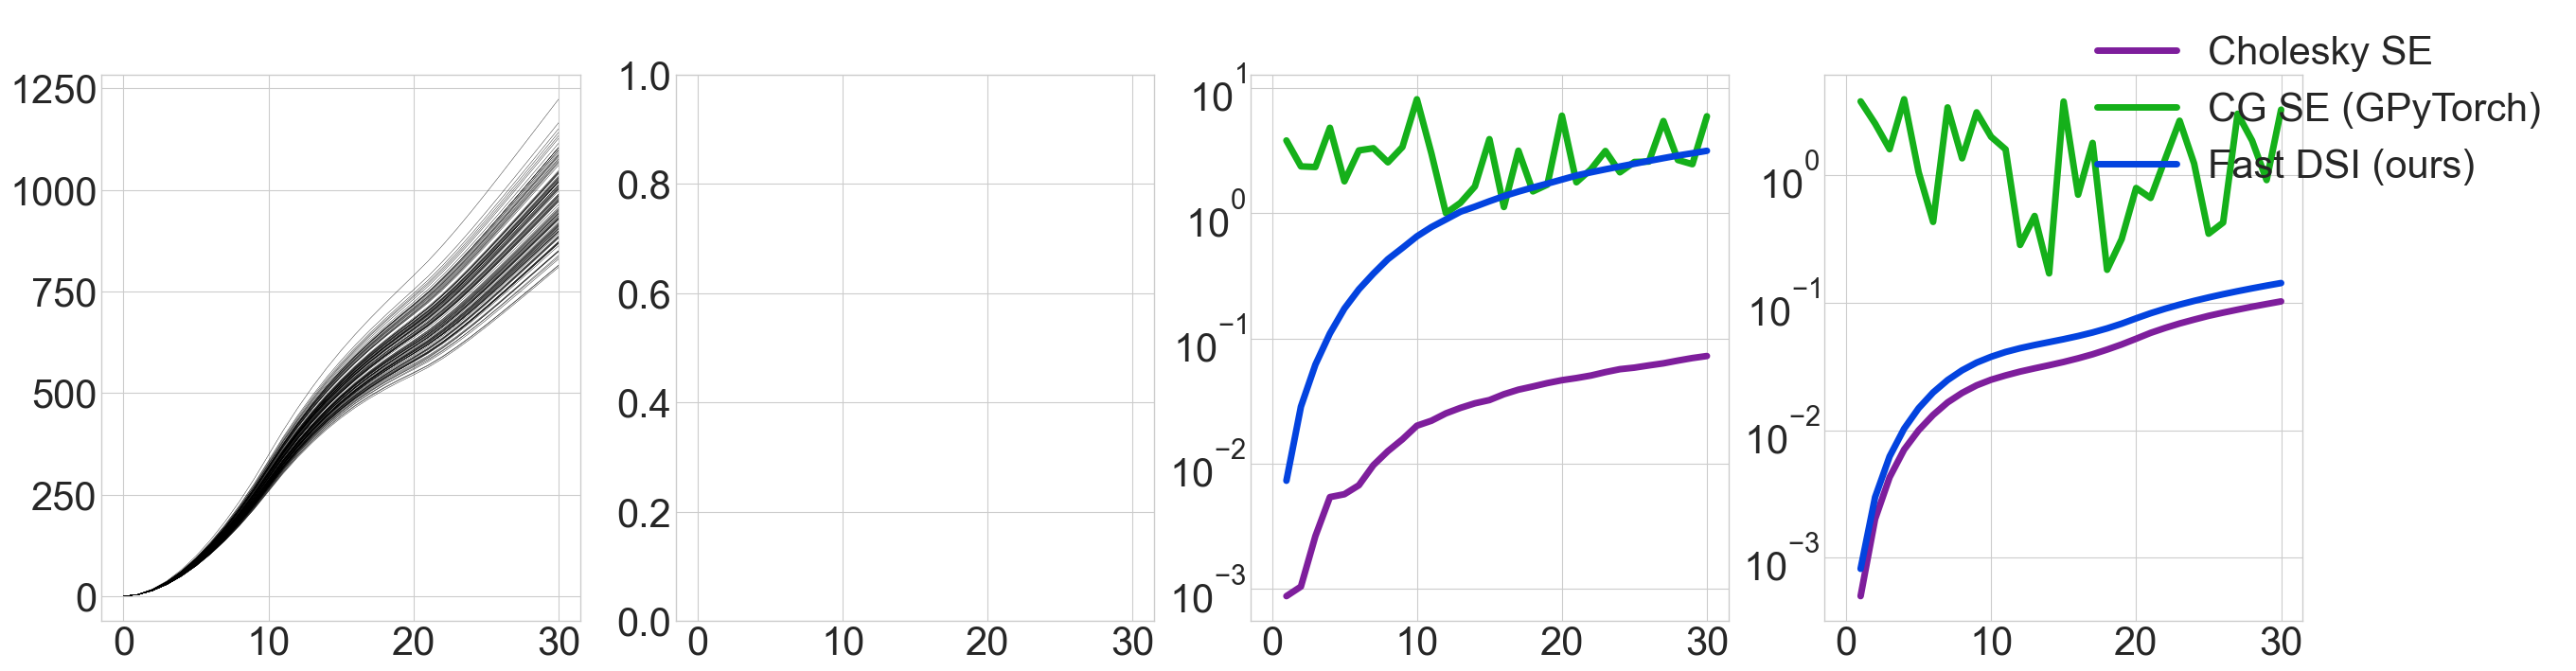

In [41]:
ALPHA = 0.25
LW = .1
gp_names = ["Cholesky SE","CG SE (GPyTorch)","Fast DSI (ours)"]
xticks = torch.arange(31)
fig,ax = pyplot.subplots(nrows=1,ncols=4,figsize=(PW,PW/4),sharex=True,sharey=False)
R = 0
for i in range(3):
    ax[0].plot(xticks,y_muq_test[:,:2**7],color='k',linewidth=LW)
    ax[2].plot(xticks[1:],torch.abs(y_muq_test-yhatts[i]).median(-1).values[1:])
    ax[3].plot(xticks[1:],torch.abs(y_muq_test.mean(-1)-muhats[i])[1:],label=gp_names[i])
ax[2].set_yscale("log",base=10)
ax[3].set_yscale("log",base=10)
fig.legend();
# ax[1,0].set_yscale("log",base=10)